In [17]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import layers

In [18]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))
x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))
AUTO = tf.data.AUTOTUNE
IMG_SIZE = 28
BATCH_SIZE = 128
EPOCHS = 2

In [19]:
def get_localization_network():
    localization = tf.keras.Sequential([
        layers.Conv2D(8, kernel_size=3, input_shape=(IMG_SIZE, IMG_SIZE, 1),
                      activation="relu", kernel_initializer="he_normal"),
        layers.MaxPool2D(strides=2),
    ])

    return localization


# Regressor for the 3 * 2 affine matrix
def get_affine_params():
    output_bias = tf.keras.initializers.Constant([1, 0, 0, 0, 1, 0])
    fc_loc = tf.keras.Sequential([
        layers.Dense(32, activation="relu", kernel_initializer="he_normal"),
        layers.Dense(3 * 2, kernel_initializer="zeros", bias_initializer=output_bias)
    ])

    return fc_loc


def get_pixel_value(img, x, y):
    shape = tf.shape(x)
    # Creating a new batch from 0 to B
    batch = tf.range(0, tf.shape(x)[0])
    # Reshaping it from 1D to 3D
    batch = tf.reshape(batch, (shape[0], 1, 1))
    # Repeat the batch along the H and W dimensions
    batch = tf.tile(batch, (1, shape[1], shape[2]))
    indices = tf.stack([batch, y, x], axis=3)

    return tf.gather_nd(img, indices)

In [20]:
def affine_grid_generator(height, width, theta):
    num_batch = tf.shape(theta)[0]
    # create normalized 2D grid
    x = tf.linspace(-1.0, 1.0, width)
    y = tf.linspace(-1.0, 1.0, height)
    x_t, y_t = tf.meshgrid(x, y)
    # flatten
    x_t_flat = tf.reshape(x_t, [-1])
    y_t_flat = tf.reshape(y_t, [-1])
    # reshape to [x_t, y_t , 1] - (homogeneous form)
    ones = tf.ones_like(x_t_flat)
    sampling_grid = tf.stack([x_t_flat, y_t_flat, ones])
    # repeat grid num_batch times
    sampling_grid = tf.expand_dims(sampling_grid, axis=0)
    sampling_grid = tf.tile(sampling_grid, tf.stack([num_batch, 1, 1]))
    # cast to float32 (required for matmul)
    theta = tf.cast(theta, 'float32')
    sampling_grid = tf.cast(sampling_grid, 'float32')
    # transform the sampling grid - batch multiply
    batch_grids = tf.matmul(theta, sampling_grid)
    # batch grid has shape (num_batch, 2, H*W)
    # reshape to (num_batch, H, W, 2)
    batch_grids = tf.reshape(batch_grids, [num_batch, 2, height, width])

    return batch_grids

In [21]:
def bilinear_sampler(img, x, y):
    H = tf.shape(img)[1]
    W = tf.shape(img)[2]
    max_y = tf.cast(H - 1, 'int32')
    max_x = tf.cast(W - 1, 'int32')
    zero = tf.zeros([], dtype='int32')
    # rescale x and y to [0, W-1/H-1]
    x = tf.cast(x, 'float32')
    y = tf.cast(y, 'float32')
    x = 0.5 * ((x + 1.0) * tf.cast(max_x - 1, 'float32'))
    y = 0.5 * ((y + 1.0) * tf.cast(max_y - 1, 'float32'))
    # grab 4 nearest corner points for each (x_i, y_i)
    x0 = tf.cast(tf.floor(x), 'int32')
    x1 = x0 + 1
    y0 = tf.cast(tf.floor(y), 'int32')
    y1 = y0 + 1
    # clip to range [0, H-1/W-1] to not violate img boundaries
    x0 = tf.clip_by_value(x0, zero, max_x)
    x1 = tf.clip_by_value(x1, zero, max_x)
    y0 = tf.clip_by_value(y0, zero, max_y)
    y1 = tf.clip_by_value(y1, zero, max_y)
    # get pixel value at corner coords
    Ia = get_pixel_value(img, x0, y0)
    Ib = get_pixel_value(img, x0, y1)
    Ic = get_pixel_value(img, x1, y0)
    Id = get_pixel_value(img, x1, y1)
    # recast as float for delta calculation
    x0 = tf.cast(x0, 'float32')
    x1 = tf.cast(x1, 'float32')
    y0 = tf.cast(y0, 'float32')
    y1 = tf.cast(y1, 'float32')
    # calculate deltas
    wa = (x1 - x) * (y1 - y)
    wb = (x1 - x) * (y - y0)
    wc = (x - x0) * (y1 - y)
    wd = (x - x0) * (y - y0)
    # add dimension for addition
    wa = tf.expand_dims(wa, axis=3)
    wb = tf.expand_dims(wb, axis=3)
    wc = tf.expand_dims(wc, axis=3)
    wd = tf.expand_dims(wd, axis=3)
    # compute output
    out = tf.add_n([wa * Ia, wb * Ib, wc * Ic, wd * Id])

    return out

In [22]:
# Spatial transformer network forward function
def stn(x):
    localization = get_localization_network()
    fc_loc = get_affine_params()

    xs = localization(x)
    xs = tf.reshape(xs, (-1, tf.shape(xs)[1] * tf.shape(xs)[2] * tf.shape(xs)[3]))
    theta = fc_loc(xs)
    theta = tf.reshape(theta, (-1, 2, 3))

    grid = affine_grid_generator(28, 28, theta)
    x_s = grid[:, 0, :, :]
    y_s = grid[:, 1, :, :]
    x = bilinear_sampler(x, x_s, y_s)

    return x

In [23]:
def get_training_model(use_stn=True):
    inputs = layers.Input((IMG_SIZE, IMG_SIZE, 1))
    x = stn(inputs) if use_stn else inputs
    x = layers.Conv2D(10, (5, 5), activation="relu", kernel_initializer="he_normal")(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(20, (5, 5), activation="relu", kernel_initializer="he_normal")(x)
    x = layers.SpatialDropout2D(0.5)(x)
    x = layers.MaxPooling2D(pool_size=(2, 2))(x)
    x = tf.reshape(x, (-1, 320))
    x = layers.Dense(50, activation="relu", kernel_initializer="he_normal")(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(10, activation="softmax")(x)
    return tf.keras.Model(inputs, outputs)

Epoch 1/2
454/454 [==============================] - 41s 84ms/step - loss: 0.7247 - accuracy: 0.7617 - val_loss: 0.1281 - val_accuracy: 0.9610 - lr: 0.0010
Epoch 2/2
79/79 [==============================] - 2s 24ms/step - loss: 0.0612 - accuracy: 0.9814
Test accuracy STN: 98.14%
Epoch 1/2
454/454 [==============================] - 16s 34ms/step - loss: 0.8932 - accuracy: 0.7006 - val_loss: 0.1712 - val_accuracy: 0.9530 - lr: 0.0010
Epoch 2/2
79/79 [==============================] - 1s 11ms/step - loss: 0.1029 - accuracy: 0.9684
Test accuracy regular: 96.84%


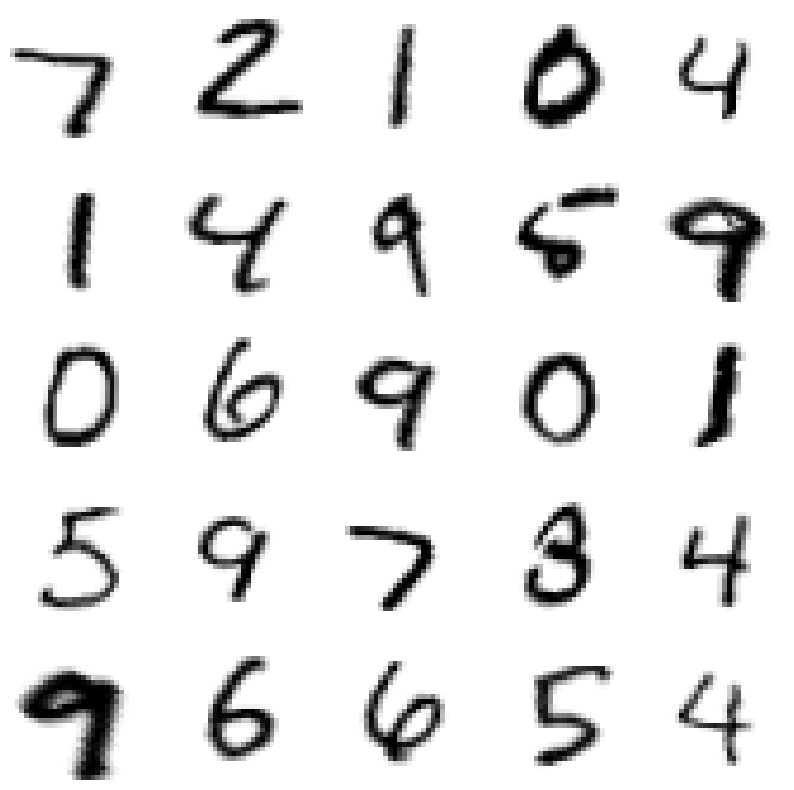

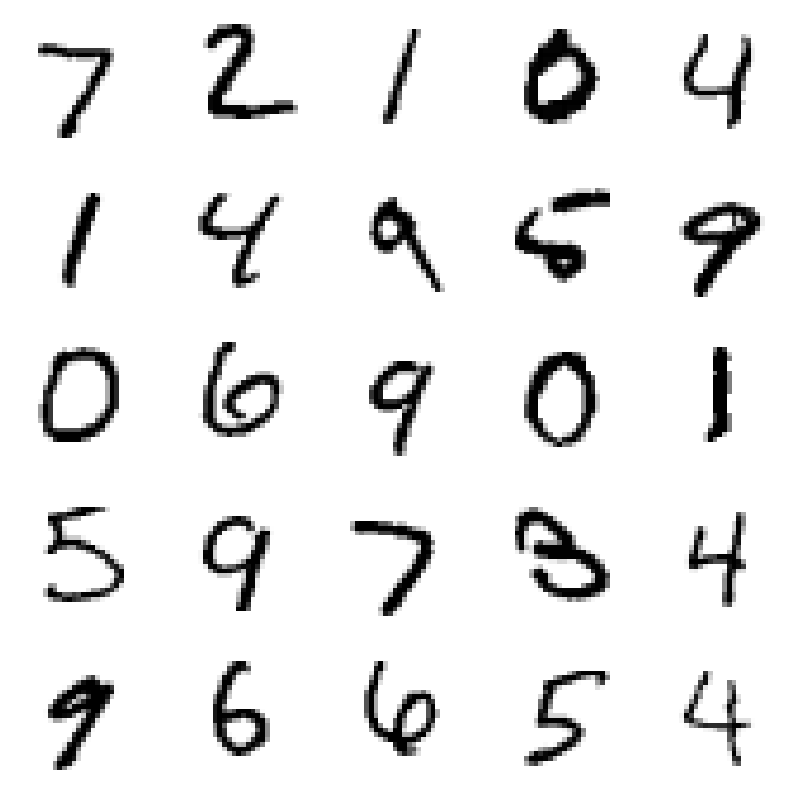

In [24]:
# Put aside a few samples to create our validation set
val_samples = 2000
x_val, y_val = x_train[:val_samples], y_train[:val_samples]
new_x_train, new_y_train = x_train[val_samples:], y_train[val_samples:]

train_ds = (
    tf.data.Dataset.from_tensor_slices((new_x_train, new_y_train))
    .shuffle(BATCH_SIZE * 100)
    .batch(BATCH_SIZE)
)

val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(BATCH_SIZE)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(BATCH_SIZE)

stn_model = get_training_model()
stn_mini_model = tf.keras.Model(stn_model.input, stn_model.layers[-10].output)

# Stop training when a monitored metric has stopped improving.
es_callback = tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)
# Reduce learning rate when a metric has stopped improving.
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau()

stn_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
stn_model.fit(train_ds, validation_data=val_ds,
              epochs=EPOCHS,
              callbacks=[es_callback, reduce_lr])

# evaluate return the loss,accuracy
_, test_acc = stn_model.evaluate(test_ds)
print("Test accuracy STN: {:.2f}%".format(test_acc * 100))

initial_model = get_training_model(use_stn=False)
initial_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
initial_model.fit(train_ds, validation_data=val_ds,
                  epochs=EPOCHS,
                  callbacks=[es_callback, reduce_lr])

# evaluate return the loss,accuracy
_, test_acc = initial_model.evaluate(test_ds)
print("Test accuracy regular: {:.2f}%".format(test_acc * 100))

sampled_transformed = stn_mini_model(x_test[:25])

plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(sampled_transformed[n].numpy().squeeze(), cmap="binary")
    plt.axis("off")
plt.show()

# Original images
plt.figure(figsize=(10, 10))
for n in range(25):
    ax = plt.subplot(5, 5, n + 1)
    plt.imshow(x_test[:25][n].squeeze(), cmap="binary")
    plt.axis("off")
plt.show()